# IRA Tweets: Analysis on Italian Tweets

# 1. Data Reading and Exploration

### Reading the data

In [127]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime
from zipfile import ZipFile

import mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
# Read the first IRA dataset
data_folder = './data/'
zip_file = ZipFile(data_folder+'russian-troll-tweets.zip')
fs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}

In [ ]:
fs['IRAhandle_tweets_1.csv'].head(1)

In [ ]:
data=pd.DataFrame()
for key,val in fs.items():
    data=pd.concat([data,val])

In [ ]:
# Read the second IRA dataset
zip_file = ZipFile(data_folder+'ira_tweets_new.zip')
interesting = ['rus_troll_tweet_text.csv',
               'rus_troll_tweet_stats.csv',
               'rus_troll_tweet_metadata.csv']
fs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename in interesting}

In [ ]:
datanew=pd.DataFrame()
for key,val in fs.items():
    datanew=pd.concat([datanew,val], axis=1, sort=False)

In [ ]:
data4 = pd.read_csv(zip_file.open('rus_troll_user.csv'))
italian_tweets = datanew[datanew.tweet_language == 'it']
italian_tweets = pd.merge(italian_tweets, data4, on ='userid')
italian_tweets.shape
italian_tweets.to_csv("italian_tweets.csv")
italian_tweets.head(20)

In [ ]:
# Read the second IRA dataset
zip_file = ZipFile(data_folder+'ira_tweets_new.zip')
data1 = pd.read_csv(zip_file.open('rus_troll_tweet_text.csv'))
data2 = pd.read_csv(zip_file.open('rus_troll_tweet_stats.csv'))
data3 = pd.read_csv(zip_file.open('rus_troll_tweet_metadata.csv'))
data4 = pd.read_csv(zip_file.open('rus_troll_user.csv'))

In [ ]:
print(data1.shape,data2.shape,data3.shape,data4.shape)

In [ ]:
data = pd.concat([data1, data2, data3], axis=1, sort=False)
italian_tweets = data[data.tweet_language == 'it']
italian_tweets = pd.merge(italian_tweets, data4, on ='userid')
italian_tweets.shape
italian_tweets.to_csv("italian_tweets.csv")
italian_tweets.head(20)

In [ ]:
data.isnull().any()

In [ ]:
data[data.region.isnull()]

In [ ]:
italian_tweets.region.unique()

In [ ]:
data.language.unique()

### Authors: following and followers

In [2]:
italian_tweets = pd.read_csv('italian_tweets.csv')
italian_tweets_old = pd.read_csv('italian_tweets_old.csv')
italian_tweets.columns

Index(['Unnamed: 0', 'tweetid', 'tweet_language', 'tweet_text', 'tweetid.1',
       'userid', 'tweet_time', 'in_reply_to_tweetid', 'in_reply_to_userid',
       'quoted_tweet_tweetid', 'is_retweet', 'retweet_userid',
       'retweet_tweetid', 'quote_count', 'reply_count', 'like_count',
       'retweet_count', 'hashtags', 'urls', 'user_mentions', 'poll_choices',
       'tweetid.2', 'follower_count_x', 'following_count_x', 'latitude',
       'longitude', 'tweet_client_name', 'user_display_name',
       'user_screen_name', 'user_reported_location',
       'user_profile_description', 'user_profile_url', 'account_creation_date',
       'account_language', 'follower_count_y', 'following_count_y',
       'last_tweet_at'],
      dtype='object')

In [3]:
italian_tweets.user_display_name.head(1)

0    378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...
Name: user_display_name, dtype: object

In [4]:
italian_tweets_old.columns

Index(['Unnamed: 0', 'external_author_id', 'author', 'content', 'region',
       'language', 'publish_date', 'harvested_date', 'following', 'followers',
       'updates', 'post_type', 'account_type', 'new_june_2018', 'retweet',
       'account_category'],
      dtype='object')

In [5]:
#italian_tweets['tweet_time'] =  pd.to_datetime(italian_tweets['tweet_time'], format='%Y/%m/%d %H:%M')
#italian_tweets_old['publish_date'] =  pd.to_datetime(italian_tweets_old['publish_date'], format='%m/%d/%Y %H:%M')

In [6]:
italian_tweets['tweet_time'] =  pd.to_datetime(italian_tweets['tweet_time'], format='%Y/%m/%d %H:%M')
italian_tweets_old['publish_date'] =  pd.to_datetime(italian_tweets_old['publish_date'], format='%m/%d/%Y %H:%M')
italian_tweets=italian_tweets.rename(index=str, columns={"user_display_name":"author",
                                                         "follower_count_x": "followers",
                                                         "following_count_x": "following",
                                                         "tweet_time":"time"})
italian_tweets_old=italian_tweets_old.rename(index=str, columns={"publish_date":"time"})
italian_tweets=italian_tweets.rename(index=str, columns={"tweet_text":"content"})

In [7]:
followers=pd.concat([italian_tweets[['author','followers','time']],italian_tweets_old[['author','followers','time']]])
followers=followers.groupby('author').agg({'followers': 'max'}).rename(columns={'followers':'max_followers'})

following=pd.concat([italian_tweets[['author','following','time']],italian_tweets_old[['author','following','time']]])
following=following.groupby('author').agg({'following': 'max'}).rename(columns={'following':'max_following'})

In [8]:
avgfollowers=pd.concat([italian_tweets[['author','followers','time']],italian_tweets_old[['author','followers','time']]])
avgfollowers=avgfollowers.groupby('author').agg({'followers': 'mean'}).rename(columns={'followers':'mean_followers'})

avgfollowing=pd.concat([italian_tweets[['author','following','time']],italian_tweets_old[['author','following','time']]])
avgfollowing=avgfollowing.groupby('author').agg({'following': 'mean'}).rename(columns={'following':'mean_following'})

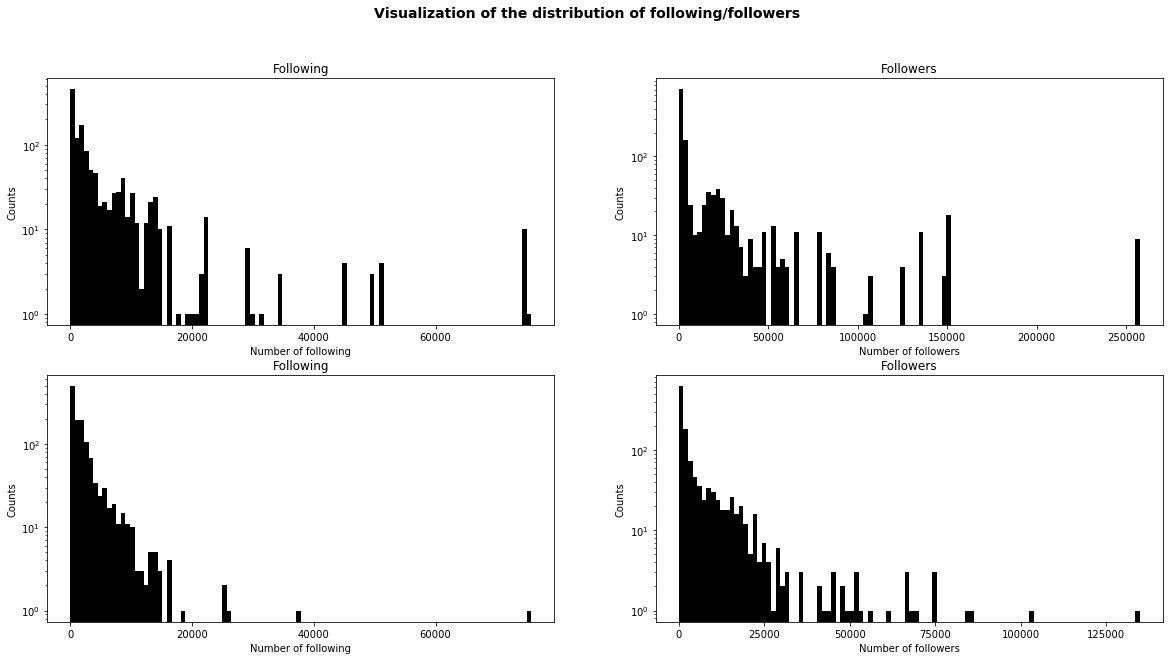

In [10]:
fig=plt.figure(figsize=(20,10))
fig.suptitle('Visualization of the distribution of following/followers', fontsize=14, fontweight='bold')

ax = fig.add_subplot(221)
ax.hist(following.max_following,bins=100,log=True,color='black')
ax.set_xlabel('Number of following')
ax.set_ylabel('Counts')
ax.set_title(r'Following')
plt.locator_params(axis='x',nbins=6)

ax2 = fig.add_subplot(222)
ax2.hist(followers.max_followers,bins=100,log=True, color='black')
ax2.set_xlabel('Number of followers')
ax2.set_ylabel('Counts')
ax2.set_title(r'Followers')
plt.locator_params(axis='x',nbins=6)

ax3 = fig.add_subplot(223)
ax3.hist(avgfollowing.mean_following,bins=100,log=True, color='black')
ax3.set_xlabel('Number of following')
ax3.set_ylabel('Counts')
ax3.set_title(r'Following')
plt.locator_params(axis='x',nbins=6)

ax4 = fig.add_subplot(224)
ax4.hist(avgfollowers.mean_followers,bins=100,log=True, color='black')
ax4.set_xlabel('Number of followers')
ax4.set_ylabel('Counts')
ax4.set_title(r'Followers')
plt.locator_params(axis='x',nbins=6)

plt.show()

In [11]:
counters=italian_tweets.groupby('author').count()
less_following = following.loc[following['max_following'] < 50000]
less_followers = followers.loc[followers['max_followers'] < 50000]

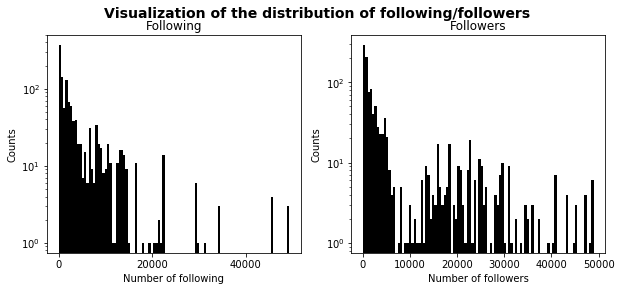

In [12]:
fig=plt.figure(figsize=(10,4))
fig.suptitle('Visualization of the distribution of following/followers', fontsize=14, fontweight='bold')
ax = fig.add_subplot(121)

ax.hist(less_following.max_following,bins=100, log=True, color='black')
ax.set_xlabel('Number of following')
ax.set_ylabel('Counts')
ax.set_title(r'Following')
plt.locator_params(axis='x',nbins=4)

ax2 = fig.add_subplot(122)
ax2.hist(less_followers.max_followers,bins=100,log=True, color='black')
ax2.set_xlabel('Number of followers')
ax2.set_ylabel('Counts')
ax2.set_title(r'Followers')

plt.show()

### Authors: activity

In [13]:
italian_tweets=italian_tweets.rename(index=str, columns={"tweet_text":"content"})
authors=pd.concat([italian_tweets[['content','author','time']],italian_tweets_old[['content','author','time']]])
authors=authors.drop_duplicates(subset='content')
authors.head()

,content,author,time
0,RT @MuseoOmero: #14marzo #paesaggioitaliano Mo...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-14 11:10:00
1,RT @Radio3tweet: La ministra @valeriafedeli in...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-16 12:38:00
2,RT @Radio1Rai: NEWS/ Attacco #Londra: May riun...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-22 17:09:00
3,RT @PiazzapulitaLA7: Assolutamente non ci alle...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-23 21:27:00
4,RT @ilmessaggeroit: Dopo Ivrea/ Le risposte ma...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-04-09 22:18:00


In [14]:
len(authors.content.unique())

35167

In [15]:
authors.content.count()

35167

In [16]:
authors.dtypes

content            object
author             object
time       datetime64[ns]
dtype: object

In [17]:
authors['time']=authors['time'].apply(lambda x: x.date())#authors.head()

In [18]:
authors=authors.groupby(['author','time']).agg('count').rename(columns={'content':'tot'})

In [19]:
authors=authors.groupby(by='author',as_index=True).agg({'tot':'mean'}).reset_index().rename(columns={'tot':'avg'})

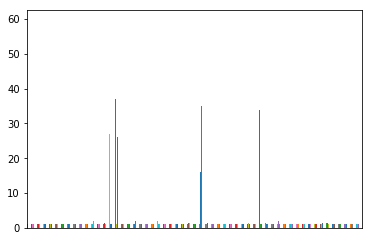

In [20]:
authors.avg.plot(kind='bar')
plt.xticks([])
plt.show()

In [21]:
tweets=pd.concat([italian_tweets[['content','author','time']],italian_tweets_old[['content','author','time']]])
tweets.describe()

,content,author,time
count,38630,38630,38630
unique,35167,1263,19852
top,"Buongiorno, Principessa!",378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-08 08:33:00
freq,23,3637,12
first,NaN,NaN,2011-02-01 21:16:00
last,NaN,NaN,2018-03-31 01:07:00


In [22]:
prolific=authors.loc[authors.avg>20]
tweets_prolific=tweets.copy().merge(prolific,how='right',on='author')
tweets_prolific=tweets_prolific[tweets_prolific['time'].apply(lambda x:x>datetime.strptime('01-01-2017', '%d-%m-%Y'))]
tweets_prolific.head()
#tweets.describe()

,content,author,time,avg
0,RT @MuseoOmero: #14marzo #paesaggioitaliano Mo...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-14 11:10:00,59.47541
1,RT @Radio3tweet: La ministra @valeriafedeli in...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-16 12:38:00,59.47541
2,RT @Radio1Rai: NEWS/ Attacco #Londra: May riun...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-22 17:09:00,59.47541
3,RT @PiazzapulitaLA7: Assolutamente non ci alle...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-23 21:27:00,59.47541
4,RT @ilmessaggeroit: Dopo Ivrea/ Le risposte ma...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-04-09 22:18:00,59.47541


### Italian politicians

In [23]:
tweets=tweets[tweets['time'].apply(lambda x:x>datetime.strptime('01-01-2017', '%d-%m-%Y'))]

In [24]:
pd.set_option('display.max_colwidth', -1)
renzi=tweets_prolific[tweets_prolific['content'].apply(lambda x: 'renzi' in x.lower())]
renzi.content.count()

481

In [25]:
pd.set_option('display.max_colwidth', -1)
renzi=tweets[tweets['content'].apply(lambda x: 'renzi' in x.lower())]
renzi.content.count()

643

In [26]:
#renzi

In [27]:
salvini=tweets_prolific[tweets_prolific['content'].apply(lambda x: 'salvini' in x.lower())]
salvini.content.count()

145

In [28]:
salvini=tweets[tweets['content'].apply(lambda x: 'salvini' in x.lower())]
#salvini=tweets.where(lambda x: 'salvini' in x.lower())
salvini.content.count()

196

In [29]:
grillo=tweets[tweets['content'].apply(lambda x: 'grillo' in x.lower())]
grillo.content.count()

172

In [66]:
rep=tweets[tweets['content'].apply(lambda x: 'repubblica' in x.lower())]
rep.content.count()

3199

### Geographical analysis 

In [61]:
munic = pd.read_excel('comuni.xls')
munic=munic.rename(columns={'Denominazione in italiano':'comune','Denominazione regione':'regione'})[['comune','regione']]
munic.comune=munic.comune.apply(lambda x: x.lower())
munic.regione=munic.regione.apply(lambda x: x.lower())
munic['count']=0
munic=munic.set_index('comune')
munic.head()

,regione,count
comune,,
agliè,piemonte,0
airasca,piemonte,0
ala di stura,piemonte,0
albiano d'ivrea,piemonte,0
alice superiore,piemonte,0


In [71]:
def count_c(nome):
    tweet_comune=tweets[tweets['content'].apply(lambda x: nome.lower() in x.lower())]
    total=tweet_comune.content.count()
    munic.at[nome, 'count']=total

In [89]:
def count_r(nome):
    tweet_reg=tweets[tweets['content'].apply(lambda x: nome.lower() in x.lower())]
    total=tweet_reg.content.count()
    reg.at[nome, 'tot']=reg.loc[nome,'tot']+total

In [72]:
list_comuni=munic.index.tolist()
for m in list_comuni:
    count_c(m)

In [87]:
reg=munic.groupby(by='regione')['count'].agg('sum').reset_index().rename(columns={'count':'tot'}).set_index('regione')

In [90]:
list_regioni=reg.index.tolist()
for m in list_regioni:
    count_r(m)

In [91]:
reg

,tot
regione,
abruzzo,4316
basilicata,1134
calabria,1233
campania,2415
emilia-romagna,15650
friuli-venezia giulia,289
lazio,5883
liguria,13286
lombardia,9476


### Time analysis

In [199]:
times=pd.concat([italian_tweets[['content','author','time']],italian_tweets_old[['content','author','time']]])
#times.loc[times['time'].apply(lambda x:x==datetime.strptime('26-03-2017', '%d-%m-%Y'))]
times=times.drop_duplicates(subset='content')

In [200]:
start_date_tweet = times['time'].min()
end_date_tweet = times['time'].max()
print(start_date_tweet, end_date_tweet)

2011-02-01 21:16:00 2018-03-31 01:07:00


In [201]:
times.dtypes

content    object        
author     object        
time       datetime64[ns]
dtype: object

In [202]:
#times=pd.concat([italian_tweets[['content','author','time']],italian_tweets_old[['content','author','time']]])
times['time']=times['time'].apply(lambda x: x.date())#authors.head()
times['time'] = pd.to_datetime(times['time'])

In [203]:
times=times.groupby(by='time',as_index=True).agg({'content':'count'}).reset_index().rename(columns={'content':'tot'})
times.sort_values(by='time', ascending = True, inplace = True)
times=times.set_index('time')

In [204]:
times.dtypes

tot    int64
dtype: object

In [205]:
times.head()

,tot
time,
2011-02-01,1
2012-07-09,11
2012-07-10,20
2012-07-11,1
2012-07-12,11


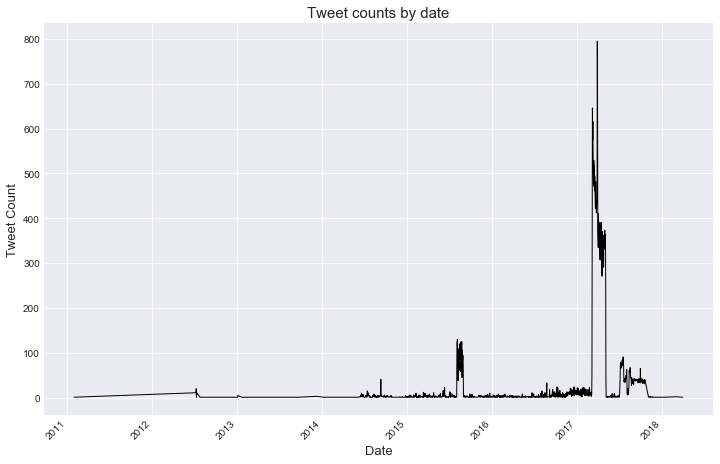

In [206]:
plt.style.use('seaborn-darkgrid')
times['tot'].plot(linestyle = "-", figsize = (12,8), rot = 45, color = 'k',
                               linewidth = 1)
plt.title('Tweet counts by date', fontsize = 15)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tweet Count', fontsize = 13)

plt.show()

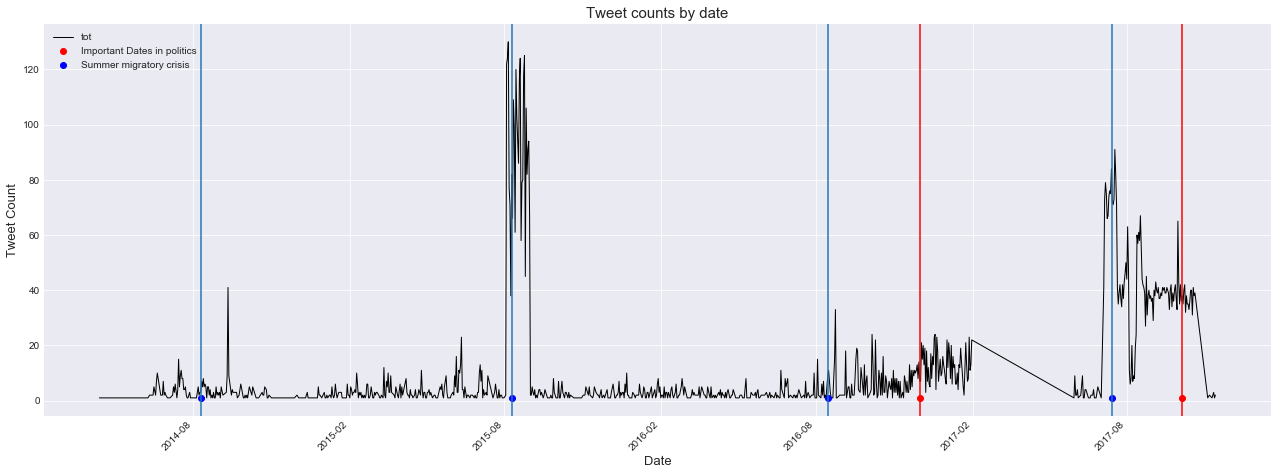

In [256]:
peak=pd.concat([italian_tweets[['content','author','time']],italian_tweets_old[['content','author','time']]])
peak=peak.drop_duplicates(subset='content')
peak=peak[peak['time'].apply(lambda x:
                         ((x<datetime.strptime('01-02-2017', '%d-%m-%Y') or 
                          (x>datetime.strptime('31-05-2017', '%d-%m-%Y'))) & 
                          (x>datetime.strptime('01-03-2014', '%d-%m-%Y')) & 
                          (x<datetime.strptime('15-11-2017', '%d-%m-%Y')))
                        )]
peak['time']=peak['time'].apply(lambda x: x.date())#authors.head()
peak['time'] = pd.to_datetime(peak['time'])
peak=peak.groupby(by='time',as_index=True).agg({'content':'count'}).reset_index().rename(columns={'content':'tot'})
peak.sort_values(by='time', ascending = True, inplace = True)
peak=peak.set_index('time')

dates_list = ['2016-12-01','2017-10-05']
# 08-2017
# March-May 2017 terror attacks in Europe: London, Stockholm, Paris, St Petersburg, Manchester
# 12-2016 Italian referendum
# 08-2015 Migratory crisis in Europe
# 05-2014 European elections
important_dates = pd.Series(pd.to_datetime(dates_list))

summer = ['2017-07-15','2016-08-15','2015-08-10','2014-08-10']
# 08-2017
# March-May 2017 terror attacks in Europe: London, Stockholm, Paris, St Petersburg, Manchester
# 12-2016 Italian referendum
# 08-2015 Migratory crisis in Europe
# 05-2014 European elections
summer_dates = pd.Series(pd.to_datetime(summer))

# add columns to identify important events, and mark a 0 or 1.
peak['Summer Events'] = False
peak.loc[summer_dates, 'Summer Events'] = True
peak['vals'] = 0
peak.loc[summer_dates, 'vals'] = 1

peak['Important Events'] = False
peak.loc[important_dates, 'Important Events'] = True
peak['values'] = 0
peak.loc[important_dates, 'values'] = 1

plt.style.use('seaborn-darkgrid')
peak['tot'].plot(linestyle = "-", figsize = (22,8), rot = 45, color = 'k',
                               linewidth = 1)
plt.title('Tweet counts by date', fontsize = 15)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tweet Count', fontsize = 13)

plt.plot(peak[peak['Important Events'] == True].index.values,
         peak.loc[peak['Important Events'] == True, 'values'],
         marker = 'o', 
         color = 'r',
         linestyle = 'none',
        label = 'Important Dates in politics')

plt.plot(peak[peak['Summer Events'] == True].index.values,
         peak.loc[peak['Summer Events'] == True, 'vals'],
         marker = 'o', 
         color = 'b',
         linestyle = 'none',
        label = 'Summer migratory crisis')

for m in peak[peak['Summer Events'] == True].index.values:
    plt.axvline(x=m)
    
for m in peak[peak['Important Events'] == True].index.values:
    plt.axvline(x=m, color='r')

plt.legend(loc = 'best')

plt.show()

# 2. Data Mining

In [110]:
italian_tweets = pd.read_csv('italian_tweets.csv')
italian_tweets_old = pd.read_csv('italian_tweets_old_notusa.csv')

In [111]:
italian_tweets['tweet_time'] =  pd.to_datetime(italian_tweets['tweet_time'], format='%Y/%m/%d %H:%M')
italian_tweets_old['publish_date'] =  pd.to_datetime(italian_tweets_old['publish_date'], format='%m/%d/%Y %H:%M')
italian_tweets=italian_tweets.rename(index=str, columns={"user_display_name":"author",
                                                         "follower_count_x": "followers",
                                                         "following_count_x": "following",
                                                         "tweet_time":"time"})
italian_tweets_old=italian_tweets_old.rename(index=str, columns={"publish_date":"time"})
italian_tweets=italian_tweets.rename(index=str, columns={"tweet_text":"content"})
ita=pd.concat([italian_tweets[['content','author','time']],italian_tweets_old[['content','author','time']]])
ita=ita.drop_duplicates(subset='content')
regex = re.compile('[^a-zA-Z ]')
def returntest(text):
    text=text.lower()
    text=regex.sub('',text) 
    text=re.sub(r'(\s)http\w+', r' ', text)
    return text
new_text = ita.content.apply(returntest)
print(new_text.head(3))
new_text.to_csv("tweets_ita.csv")

0    rt museoomero marzo paesaggioitaliano mole vanvitelliana ancona un pentagono adagiato sullacqua dal  un exlazzaretto oggi sed
1    rt radiotweet la ministra valeriafedeli incontra gli studenti di amatrice negli studi di via asiago qui  raipo               
2    rt radiorai news attacco londra may riunisce comitato demergenza cobra                                                       
Name: content, dtype: object


### Association Rules

In [112]:
italian_tweets_text = pd.read_csv('tweets_ita.csv',header=None)
print(italian_tweets_text.shape)
stopwords = pd.read_json('stopwords-it.json')

(35167, 2)


In [113]:
stopwords = stopwords[0].tolist()

In [135]:
list_final = []
for text in italian_tweets_text[1]:
    list_final.append([word.lower() for word in text.split() 
                       if (word.lower() not in stopwords and
                           (len(word)>3 or word in ['pd','ms']))])
    
list_final

In [119]:
te = TransactionEncoder()
te_ary = te.fit(list_final).transform(list_final)
df = pd.DataFrame(te_ary,columns=te.columns_)

In [121]:
frequent_items = apriori(df, min_support=0.001, use_colnames=True, max_len = 2)

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.


In [ ]:
couple = frequent_items [frequent_items['itemsets'].apply(lambda x: len(x)==2)]
couple = couple.sort_values(by=['support'],ascending= False)

In [ ]:
table = association_rules(frequent_items, metric="confidence", min_threshold=0.2)
table = table.sort_values(by=['confidence'],ascending= False)

In [ ]:
single = frequent_items [frequent_items['itemsets'].apply(lambda x: len(x)==1)]
single = single.sort_values(by=['support'],ascending= False)

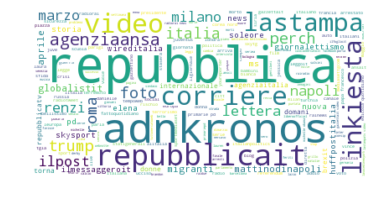

In [128]:
text = " ".join([word for tweet in list_final for word in tweet])
wordcloud = WordCloud(background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

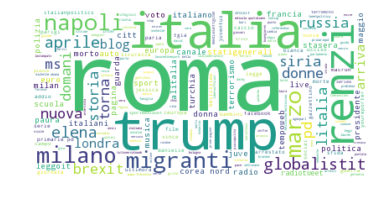

In [143]:
papers=['Corriere della Sera','repubblica','repubblicait','SoleORE','QuotidianoNazionale',
        'Gazzettait','laStampa','ilMessaggeroit','quotidianonazionale','ilpost',
        'corriere','ilgiornale','Avvenire','Tuttosport','libero',
        'FattoQuotidiano','Mattinodinapoli','huffpost','linkiesta',
        'adnkronos','agenziaansa','video','giornalettismo','ilpost',
        'lettera','huffpostitalia','agenziaitalia','skytg','skysport','internazionale',
        'perch','foto','repubblicatv','wireditalia','news','diretta','leggo','radiorai']
papers=[m.lower() for m in papers]
text = " ".join([word for tweet in list_final for word in tweet if word not in papers])
wordcloud = WordCloud(background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()